In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yfinance as yf
import datetime as dt


#from data_handler import get_sp500_ticker_list
from data_handler import get_adj_close
#from data_handler import sp500_closes_to_csv

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy import stats
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Setting some default layout options for plots
sns.set_style("whitegrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

# Getting the data

In [3]:
start='2018-01-01'
end='2020-12-31'
interval='1d'
ticker_list = ['AAPL', 'NVDA', 'FTNT']

df = get_adj_close(ticker_list, start, end, interval)

[*********************100%***********************]  3 of 3 completed


In [4]:
df.head()

,AAPL,FTNT,NVDA
Date,,,
2018-01-02,41.075405,44.349998,49.372395
2018-01-03,41.068253,45.029999,52.621780
2018-01-04,41.259014,44.000000,52.899166
2018-01-05,41.728767,44.099998,53.347443
2018-01-08,41.573757,45.000000,54.982040


# Analyze data

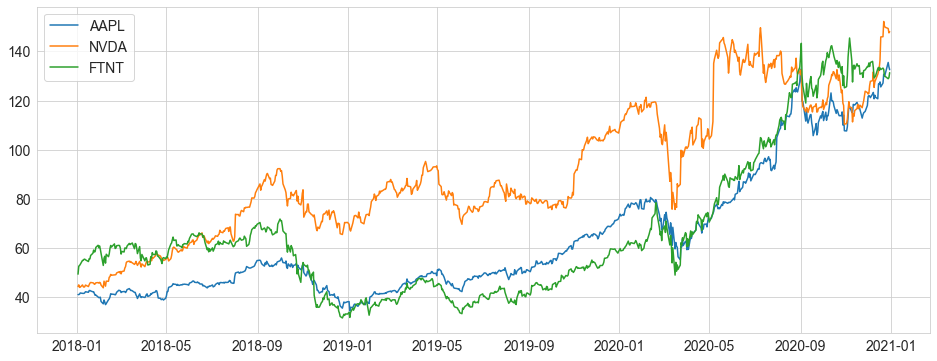

In [5]:
#plotting adjusted close price
plt.plot(df)
plt.legend(ticker_list)
plt.show()

In [6]:
#Computing the daily returns
returns = (df.pct_change())*100
returns.dropna(axis=0,inplace=True)
print(returns)

                AAPL      FTNT      NVDA
Date                                    
2018-01-03 -0.017413  1.533259  6.581382
2018-01-04  0.464499 -2.287361  0.527131
2018-01-05  1.138547  0.227269  0.847417
2018-01-08 -0.371471  2.040820  3.064060
2018-01-09 -0.011451 -1.511112 -0.027017
...              ...       ...       ...
2020-12-23 -0.697608 -1.255333 -2.025881
2020-12-24  0.771220 -0.299529 -0.119152
2020-12-28  3.576559 -0.333801 -0.721502
2020-12-29 -1.331478 -1.178910  0.335274
2020-12-30 -0.852655  0.332140  1.564522

[754 rows x 3 columns]


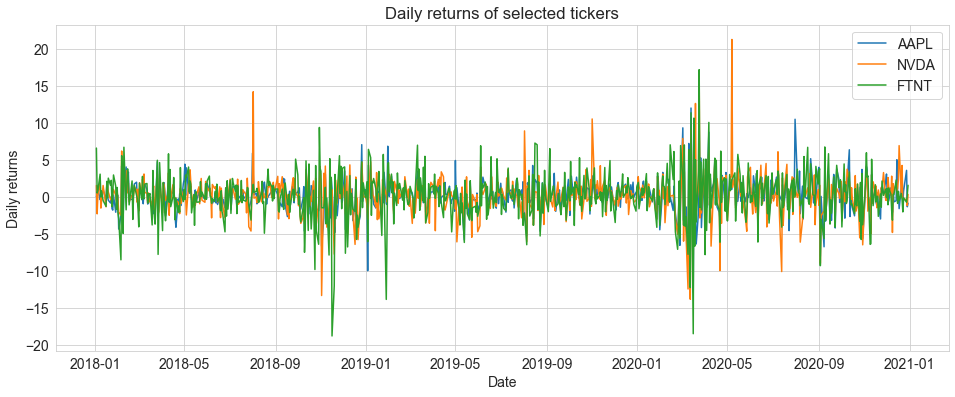

In [7]:
#plotting the returns
plt.plot(returns)
plt.title('Daily returns of selected tickers')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.legend(ticker_list)
plt.show()

C:\Users\antoi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


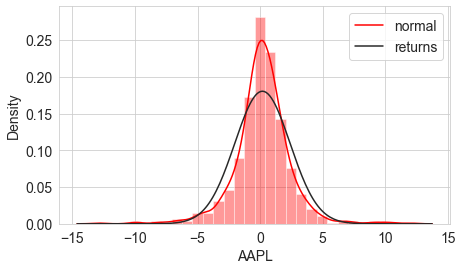

In [8]:
#plotting histograms to inspect distribution of the returns. We can clearly see fatter tails
plt.figure(figsize=(7,4))
sns.distplot(returns['AAPL'], norm_hist=True, fit=stats.norm, bins=30, color='r')
plt.legend(('normal', 'returns'))
plt.show()

In [9]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [10]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

C:\Users\antoi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


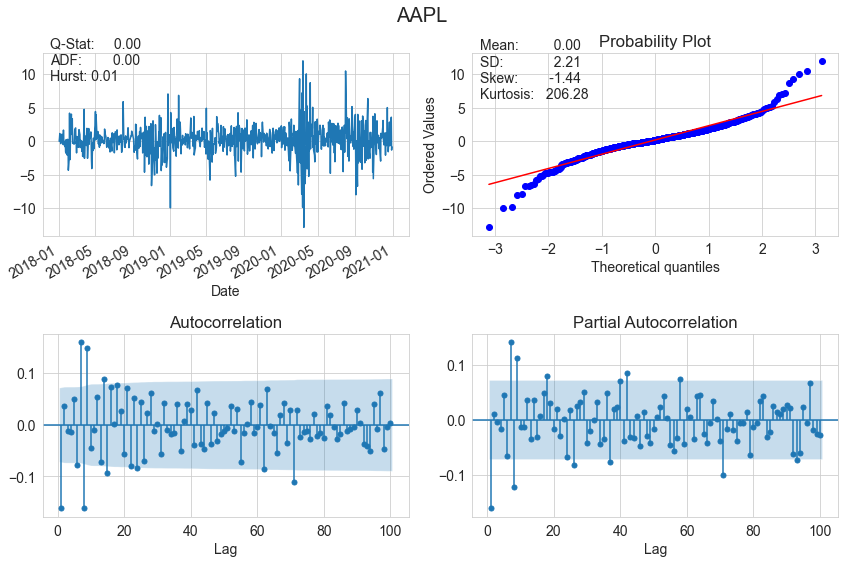

In [11]:
plot_correlogram(returns['AAPL'],lags=100, title="AAPL")

In [12]:
#Creating train and test sets (not the best way to proceed...)
#train_aapl = df.loc["2018-01-01":"2020-11-30","AAPL"]
#test_aapl = df.loc["2020-12-01":"2020-12-31","AAPL"]
#test_aapl

In [13]:
split_date = dt.datetime(2020,12,1)

# Modelling volatility with GARCH

In [14]:
#finding the best parameters
aic_garch = []

for p in range(1, 11): 
    for q in range(1,11):
        garch = arch_model(returns['AAPL'], mean='zero', vol='GARCH', p=p, q=q)\
            .fit(disp='off') 
        aic_garch.append(garch.aic) 
    
        if garch.aic == np.min(aic_garch): 
            best_param = (p,q) 
print(best_param) 

(3, 3)


In [15]:
#fitting the GARCH model on the train data set
garch = arch_model(returns['AAPL'], mean='zero', vol='GARCH', p=best_param[0], q=best_param[1])
garch_results = garch.fit(disp='off', last_obs=split_date)
print(garch_results.summary)

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1514.14
Distribution:                  Normal   AIC:                           3042.28
Method:            Maximum Likelihood   BIC:                           3074.46
                                        No. Observations:                  733
Date:                Tue, May 10 2022   Df Residuals:                      733
Time:                        11:10:43   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.539

# Analytical forecasts

<AxesSubplot:xlabel='Date'>

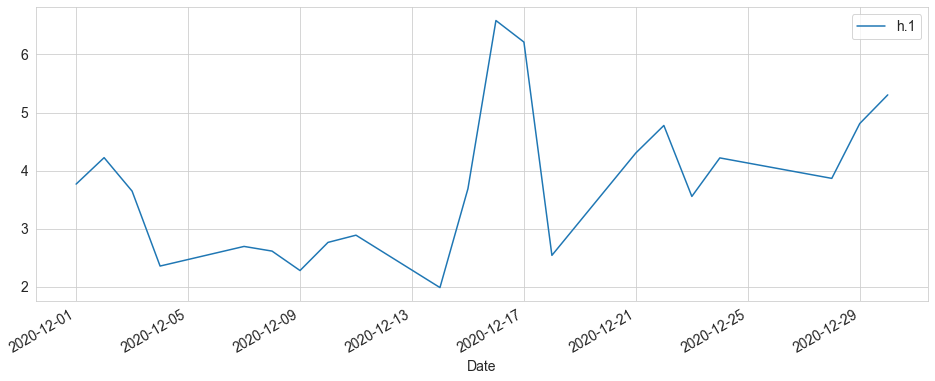

In [16]:
forecasts_aapl = garch_results.forecast(horizon=1, start=split_date, reindex=False)
forecasts_aapl.variance[split_date:].plot()

In [17]:
print(forecasts_aapl.variance)

                 h.1
Date                
2020-12-01  3.767671
2020-12-02  4.223032
2020-12-03  3.646487
2020-12-04  2.356131
2020-12-07  2.694152
2020-12-08  2.613764
2020-12-09  2.278861
2020-12-10  2.763613
2020-12-11  2.887722
2020-12-14  1.985456
2020-12-15  3.688723
2020-12-16  6.584918
2020-12-17  6.213769
2020-12-18  2.540448
2020-12-21  4.304264
2020-12-22  4.777199
2020-12-23  3.555139
2020-12-24  4.218747
2020-12-28  3.866075
2020-12-29  4.810857
2020-12-30  5.304240


# Simulation forecasts

<AxesSubplot:xlabel='Date'>

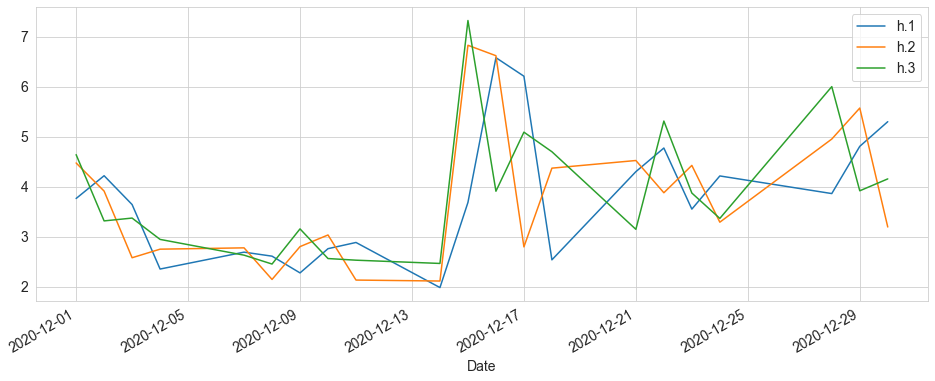

In [18]:
simu_forecasts_aapl = garch_results.forecast(horizon=3, start=split_date, method="simulation", reindex=False)
simu_forecasts_aapl.variance[split_date:].plot()

In [19]:
#computing realized volatility
realized_vol = returns.loc[(split_date-dt.timedelta(7)):,:].rolling(5).std()
realized_vol.dropna(axis=0, inplace=True)
realized_vol

,AAPL,FTNT,NVDA
Date,,,
2020-12-01,1.071711,1.546059,1.315305
2020-12-02,1.205455,1.561821,0.877844
2020-12-03,1.363003,1.784015,0.910953
2020-12-04,1.560446,1.327126,1.004096
2020-12-07,1.443679,1.217568,0.946007
2020-12-08,0.673010,1.250652,1.379767
2020-12-09,1.250034,3.107003,1.736412
2020-12-10,1.402725,2.979917,1.813295
2020-12-11,1.415921,2.930809,1.620294


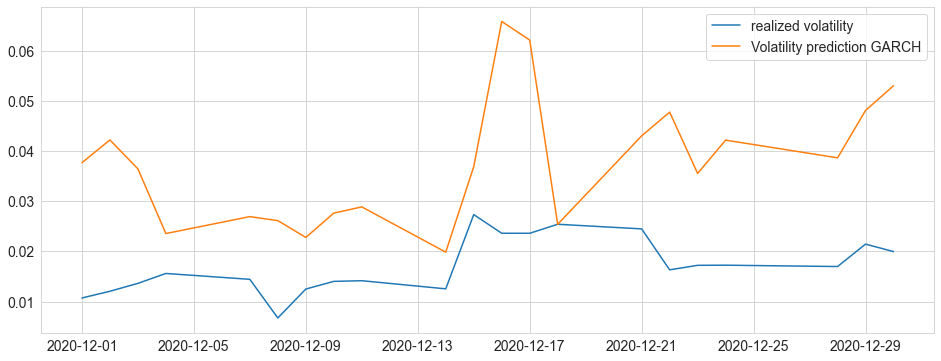

In [20]:
#plotting realized volatility vs volatility prediction with GARCH
plt.plot(realized_vol['AAPL'] /100, label="realized volatility")
plt.plot(forecasts_aapl.variance/100, label="Volatility prediction GARCH")
plt.legend()
plt.show()

# EGARCH

In [21]:
aic_egarch = []

for p in range(1, 11):
    for q in range(1, 11):
        egarch = arch_model(returns['AAPL'], mean='zero', vol='EGARCH', p=p, q=q)\
              .fit(disp='off')
        aic_egarch.append(egarch.aic)
        if egarch.aic == np.min(aic_egarch):
            best_param = (p, q)
print(best_param)

(3, 3)


In [22]:
egarch = arch_model(returns['AAPL'], mean='zero', vol='EGARCH',
                 p=best_param[0], q=best_param[1])\
      .fit(disp='off',last_obs=split_date)
print(egarch.summary())
forecasts_egarch = egarch.forecast(start=split_date)

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                     EGARCH   Log-Likelihood:               -1511.26
Distribution:                  Normal   AIC:                           3036.53
Method:            Maximum Likelihood   BIC:                           3068.71
                                        No. Observations:                  733
Date:                Tue, May 10 2022   Df Residuals:                      733
Time:                        11:10:48   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2370      0.107      2.205  2.745e-02 [2.635e-0

C:\Users\antoi\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


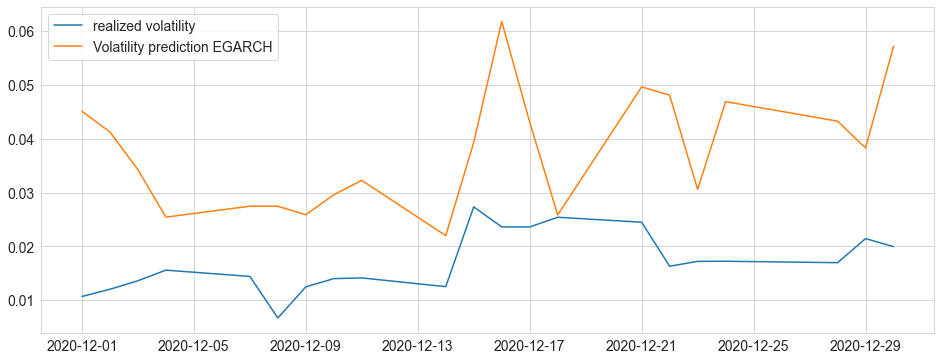

In [23]:
#plotting realized volatility vs volatility prediction with GARCH
plt.plot(realized_vol['AAPL'] /100, label="realized volatility")
plt.plot(forecasts_egarch.variance/100, label="Volatility prediction EGARCH")
plt.legend()
plt.show()

# SVM

In [24]:
realized_vol_aapl = returns['AAPL'].rolling(5).std()
realized_vol_aapl = pd.DataFrame(realized_vol_aapl)
realized_vol_aapl.reset_index(drop=True, inplace=True)
realized_vol_aapl

,AAPL
0,NaN
1,NaN
2,NaN
3,NaN
4,0.583346
...,...
749,1.722876
750,1.725333
751,1.698701
752,2.145497


In [25]:
returns_svm = returns['AAPL'] ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']
returns_svm

,AAPL
0,0.000303
1,0.215759
2,1.296289
3,0.137991
4,0.000131
...,...
749,0.486657
750,0.594780
751,12.791774
752,1.772834


In [26]:
X = pd.concat([realized_vol_aapl, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)
X

,0,1
0,0.583346,0.000131
1,0.583962,0.000526
2,0.595654,0.322644
3,0.557253,1.066333
4,0.596665,0.258289
...,...,...
745,1.722876,0.486657
746,1.725333,0.594780
747,1.698701,12.791774
748,2.145497,1.772834


In [27]:
realized_vol = realized_vol.dropna().reset_index()
#realized_vol.drop('index', axis=1, inplace=True)

In [28]:
svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

In [29]:
realized_vol_aapl.dropna(axis=0, inplace=True)

In [30]:
n=21
para_grid = {'gamma': sp_rand(),
             'C': sp_rand(),
             'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values, realized_vol_aapl.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

In [34]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = returns['AAPL'].iloc[-n:].index

In [37]:
predict_svr_lin

,0
Date,
2020-12-01,1.246826
2020-12-02,1.264094
2020-12-03,1.395434
2020-12-04,1.563998
2020-12-07,1.478100
2020-12-08,0.819475
2020-12-09,1.344611
2020-12-10,1.443081
2020-12-11,1.444235


In [35]:
realized_vol_aapl.index = returns['AAPL'].iloc[4:].index
realized_vol_aapl.index

DatetimeIndex(['2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19',
               '2018-01-22', '2018-01-23',
               ...
               '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-21',
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='Date', length=750, freq=None)

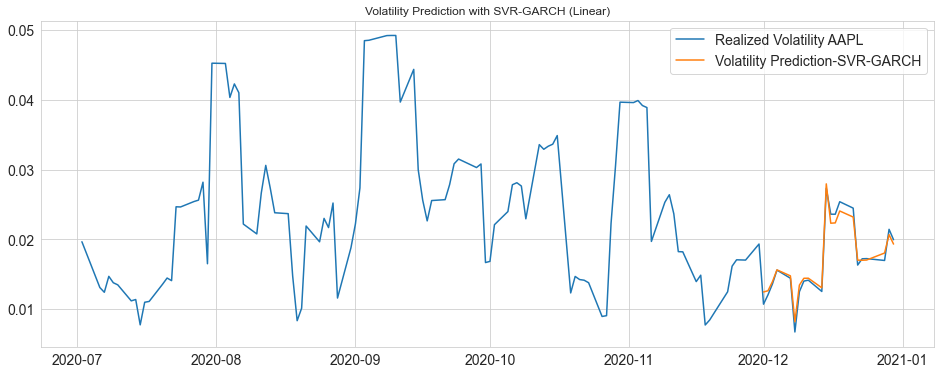

In [39]:
plt.plot(realized_vol_aapl[-126:] / 100, label='Realized Volatility AAPL')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()